In [2]:
# --- Cellule 0: Setup (chemins + imports) ---
import os, re, glob, numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ↘︎ Chemin ABSOLU vers ton dossier de résultats V1
BASE = "/Users/assiaoumri/Desktop/Scolarité/IPSSI/GAN_PROJET/GAN_Project/gan_v1_results_1000epochs-2"

HIST_FILE   = os.path.join(BASE, "training_history.npz")
GEN_DIRS_V1 = [os.path.join(BASE, "generated_images")]
PLOTS_DIR   = os.path.join(BASE, "plots")

os.makedirs(PLOTS_DIR, exist_ok=True)

print("HIST_FILE ->", HIST_FILE, "exists:", os.path.exists(HIST_FILE))
print("GEN_DIRS_V1[0] ->", GEN_DIRS_V1[0], "isdir:", os.path.isdir(GEN_DIRS_V1[0]))
print("PLOTS_DIR ->", PLOTS_DIR)

# Sanity check des .png disponibles
pngs = glob.glob(os.path.join(GEN_DIRS_V1[0], "*.png"))
print("Nb PNG trouvés dans generated_images:", len(pngs))
if pngs[:5]:
    print("Exemples:", [os.path.basename(p) for p in sorted(pngs)[:5]])


HIST_FILE -> /Users/assiaoumri/Desktop/Scolarité/IPSSI/GAN_PROJET/GAN_Project/gan_v1_results_1000epochs-2/training_history.npz exists: True
GEN_DIRS_V1[0] -> /Users/assiaoumri/Desktop/Scolarité/IPSSI/GAN_PROJET/GAN_Project/gan_v1_results_1000epochs-2/generated_images isdir: True
PLOTS_DIR -> /Users/assiaoumri/Desktop/Scolarité/IPSSI/GAN_PROJET/GAN_Project/gan_v1_results_1000epochs-2/plots
Nb PNG trouvés dans generated_images: 11
Exemples: ['epoch_10.png', 'epoch_100.png', 'epoch_1000.png', 'epoch_200.png', 'epoch_300.png']


In [4]:
# --- Cellule 1 (corrigée): Chargement de l'historique V1 ---
import numpy as np

if not os.path.exists(HIST_FILE):
    raise FileNotFoundError(f"Introuvable: {HIST_FILE}")

data = np.load(HIST_FILE, allow_pickle=True)
print("Clés du .npz:", list(data.keys()))

# Vos clés:
g_loss = data.get('generator_losses')
d_loss = data.get('discriminator_losses')

# Convertir en np.array si ce sont des listes
if g_loss is not None: g_loss = np.asarray(g_loss)
if d_loss is not None: d_loss = np.asarray(d_loss)

# Déterminer la longueur commune (ignorer None)
n_g = len(g_loss) if g_loss is not None else 0
n_d = len(d_loss) if d_loss is not None else 0
n = max(n_g, n_d)  # on prend le max pour visualiser tout ce qu'on a

# Construire un vecteur d'epochs si absent
epochs = np.arange(1, n + 1)

print(f"Tailles → epochs: {len(epochs)} | gen: {n_g} | disc: {n_d}")
if n_g > 0:
    print("generator_losses: head=", g_loss[:3], "tail=", g_loss[-3:])
if n_d > 0:
    print("discriminator_losses: head=", d_loss[:3], "tail=", d_loss[-3:])


Clés du .npz: ['generator_losses', 'discriminator_losses']
Tailles → epochs: 1000 | gen: 1000 | disc: 1000
generator_losses: head= [0.78681397 1.4075371  1.96699274] tail= [4.27381516 6.63306618 4.79757071]
discriminator_losses: head= [1.26231158 0.68475199 0.67146254] tail= [0.13622941 0.2227726  0.1624766 ]


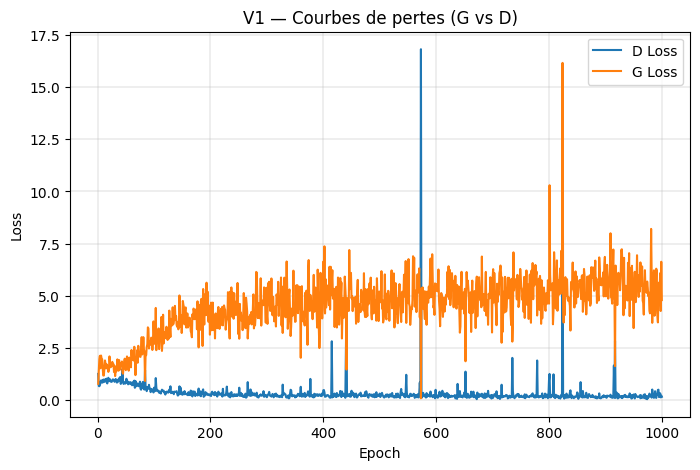

Figure sauvegardée → /Users/assiaoumri/Desktop/Scolarité/IPSSI/GAN_PROJET/GAN_Project/gan_v1_results_1000epochs-2/plots/v1_losses.png | exists: True


In [5]:
# --- Cellule 2 (corrigée): Courbes de pertes G/D ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

plotted = False
if d_loss is not None and len(d_loss) > 0:
    plt.plot(epochs[:len(d_loss)], d_loss, label="D Loss")
    plotted = True
if g_loss is not None and len(g_loss) > 0:
    plt.plot(epochs[:len(g_loss)], g_loss, label="G Loss")
    plotted = True

if not plotted:
    raise ValueError("Aucune série de pertes non vide à tracer (generator_losses / discriminator_losses sont vides).")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("V1 — Courbes de pertes (G vs D)")
plt.legend()
plt.grid(True, linewidth=0.3)

fig_path = os.path.join(PLOTS_DIR, "v1_losses.png")
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
plt.show()
print("Figure sauvegardée →", fig_path, "| exists:", os.path.exists(fig_path))


In [7]:
# --- Cellule 3 : Helpers pour retrouver les images par epoch ---
import re, os

def match_epoch_from_filename(name: str):
    """Extrait le numéro d’epoch depuis le nom du fichier."""
    m = re.search(r'(\d{1,5})', name)
    return int(m.group(1)) if m else None

def find_image_for_epoch(img_dir: str, target_epoch: int, tolerance: int = 3):
    """Cherche un .png dont l’epoch est target_epoch (± tolerance)."""
    pngs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith('.png')])
    by_ep = {}
    for f in pngs:
        ep = match_epoch_from_filename(f)
        if ep is not None:
            by_ep[ep] = f
    if target_epoch in by_ep:
        return os.path.join(img_dir, by_ep[target_epoch])
    # sinon, cherche la plus proche
    closest, best = None, None
    for ep in by_ep:
        d = abs(ep - target_epoch)
        if d <= tolerance and (best is None or d < best):
            best, closest = d, ep
    return None if closest is None else os.path.join(img_dir, by_ep[closest])

# (optionnel) voir quelles epochs existent réellement
available_epochs = sorted(
    e for e in (match_epoch_from_filename(f) for f in os.listdir(GEN_DIRS_V1[0]))
    if e is not None
)
print("Epochs disponibles :", available_epochs)


Epochs disponibles : [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


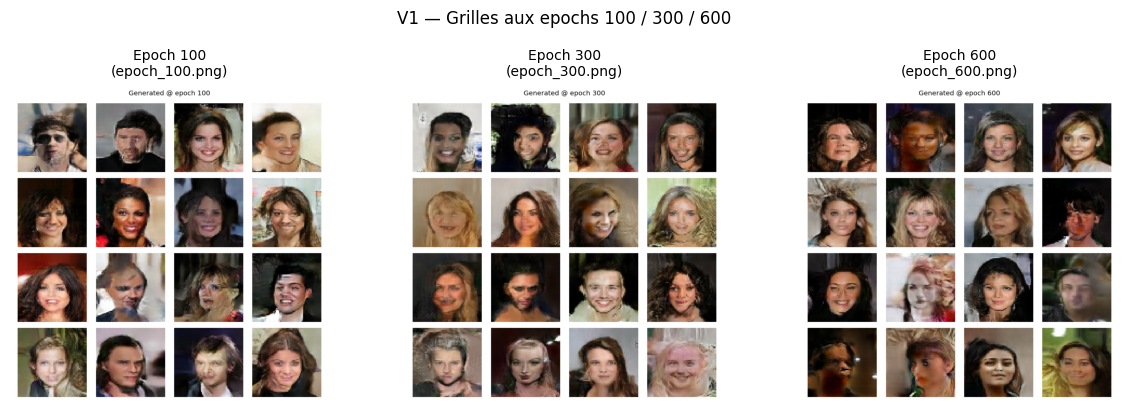

Grilles sauvegardées → /Users/assiaoumri/Desktop/Scolarité/IPSSI/GAN_PROJET/GAN_Project/gan_v1_results_1000epochs-2/plots/v1_grids_100_300_600.png | exists: True


In [8]:
# --- Cellule 4 : Affichage des grilles 100 / 300 / 600 ---
import matplotlib.pyplot as plt
from PIL import Image
import os

targets = [100, 300, 600]   # demandé par Hakim
img_dir = GEN_DIRS_V1[0]    # ton dossier generated_images

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ep in enumerate(targets):
    ax = axes[i]
    # tes fichiers semblent nommés "epoch_<n>.png", donc on force l'accès direct :
    fname = f"epoch_{ep}.png"
    path = os.path.join(img_dir, fname)
    if os.path.exists(path):
        ax.imshow(Image.open(path)); ax.axis("off")
        ax.set_title(f"Epoch {ep}\n({fname})", fontsize=10)
    else:
        ax.text(0.5, 0.5, f"Image epoch {ep}\nnon trouvée", ha="center", va="center")
        ax.axis("off")

plt.suptitle("V1 — Grilles aux epochs 100 / 300 / 600", y=1.02)
plt.tight_layout()

grid_path = os.path.join(PLOTS_DIR, "v1_grids_100_300_600.png")
plt.savefig(grid_path, dpi=150, bbox_inches="tight")
plt.show()
print("Grilles sauvegardées →", grid_path, "| exists:", os.path.exists(grid_path))


Exemples de fichiers: ['epoch_10.png', 'epoch_100.png', 'epoch_1000.png', 'epoch_200.png', 'epoch_300.png', 'epoch_400.png', 'epoch_500.png', 'epoch_600.png', 'epoch_700.png', 'epoch_800.png']
Aperçu -> epoch_500.png


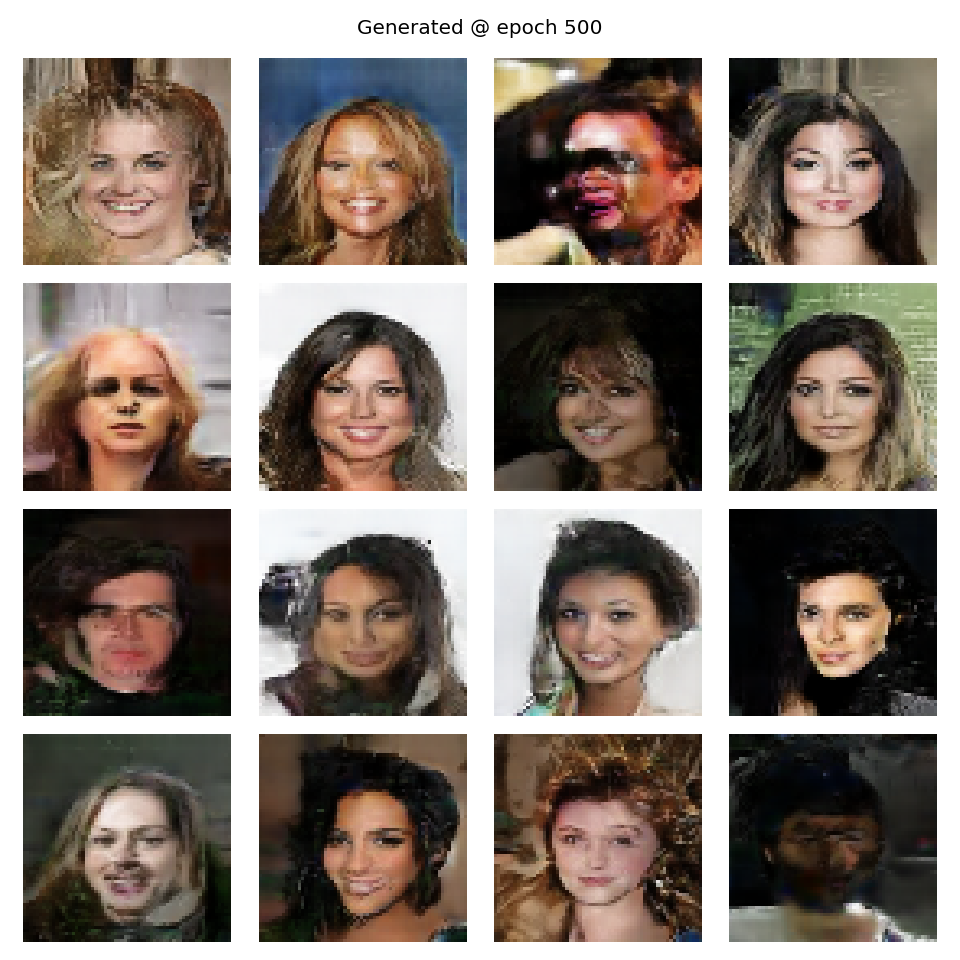

In [9]:
# --- Cellule 5 (optionnel): aperçu rapide d'images disponibles ---
import random
samples = sorted(glob.glob(os.path.join(GEN_DIRS_V1[0], "*.png")))[:10]
print("Exemples de fichiers:", [os.path.basename(s) for s in samples])

# Affiche une image au hasard
if samples:
    p = random.choice(samples)
    print("Aperçu ->", os.path.basename(p))
    display(Image.open(p))


## ✅ Conclusion — V1 Baseline

- **Convergence** : La courbe montre une D Loss qui diminue rapidement (≈1.2 → 0.1) et reste stable, tandis que la G Loss oscille entre 4 et 7 sur la durée. Cela traduit un entraînement équilibré : le discriminateur apprend vite à distinguer le vrai du faux, et le générateur continue à progresser sans effondrement.

- **Qualité visuelle** :
  - **Epoch 100** : silhouettes floues, contours imprécis, visages encore peu structurés.  
  - **Epoch 300** : traits faciaux plus nets, teintes de peau mieux équilibrées, diversité correcte entre les visages.  
  - **Epoch 600** : visages globalement reconnaissables, certains très réalistes, même si des artefacts persistent (zones floues, yeux mal définis).

- **Verdict** : V1 converge correctement. Le modèle parvient à générer des visages réalistes et variés, preuve d’un apprentissage efficace du générateur et d’une bonne stabilité du discriminateur.

- **Limites** : Quelques flous résiduels, artefacts autour des yeux et cheveux, et arrière-plans souvent similaires. L’introduction d’un module d’attention (CBAM) ou d’une régularisation spectrale pourrait améliorer la cohérence spatiale et la diversité visuelle.
